## Classifying tweet sentiment

In [65]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

import matplotlib.pyplot as plt
import numpy as np

from argparse import Namespace
from nltk.tokenize import word_tokenize
from sentiment.tass import InterTASSReader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

from sentiment import tokenizer, preprocessor

### Load dataset

In [66]:
sentiment_classes = ['P', 'N', 'NEU', 'NONE']

def y_text_to_num(y_text):
    return [sentiment_classes.index(elem) for elem in y_text]

def y_num_to_text(y_num):
    return [sentiment_classes[index] for index in y_num]

In [67]:
corpus_file = '../../corpus/tass/intertass-ES-{}-tagged.xml'

reader = InterTASSReader(corpus_file.format('train'))
X_train = list(reader.X())
y_train = y_text_to_num(reader.y())

reader = InterTASSReader(corpus_file.format('development'))
X_dev = list(reader.X())
y_dev = y_text_to_num(reader.y())

In [68]:
# Class distribution
for i, output in enumerate(sentiment_classes):
    print(output, (torch.tensor(y_train) == i).sum().item())

P 318
N 418
NEU 133
NONE 139


### Vectorizer

In [69]:
tokenize = tokenizer.Tokenizer(max_negations=0, filter_stopwords=True)
preprocess = preprocessor.Preprocessor()
#vectorizer = CountVectorizer(binary=True)
#vectorizer = CountVectorizer(binary=True, analyzer='char', ngram_range=(3, 5))
vectorizer = CountVectorizer(binary=True, tokenizer=tokenize, preprocessor=preprocess)
vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1),
                preprocessor=<sentiment.preprocessor.Preprocessor object at 0x7f6f277a62b0>,
                stop_words=None, strip_accents=None,
                token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<sentiment.tokenizer.Tokenizer object at 0x7f6f277a6278>,
                vocabulary=None)

In [70]:
input_shape = vectorizer.transform([X_train[0]]).shape
input_shape

(1, 3947)

In [71]:
X_train = vectorizer.transform(X_train).toarray()
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).long()
X_dev = vectorizer.transform(X_dev).toarray()
X_dev = torch.tensor(X_dev).float()
y_dev = torch.tensor(y_dev).long()

### Multi-layer perceptron

In [72]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        hid_dim_1 = 800
        self.l1 = nn.Linear(input_dim, hid_dim_1)
        self.l2 = nn.Linear(hid_dim_1, output_dim)
        
    def forward(self, X, apply_softmax=True):
        X_t = torch.sigmoid(self.l1(X))
        X_t = self.l2(X_t)
        if apply_softmax:
            X_t = F.softmax(X_t, dim=1)
        return X_t

In [73]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        hid_dim_1 = 400
        hid_dim_2 = 100
        self.l1 = nn.Linear(input_dim, hid_dim_1)
        self.do1 = nn.Dropout(p=0.5)
        self.l2 = nn.Linear(hid_dim_1, hid_dim_2)
        self.do2 = nn.Dropout(p=0.5)
        self.l3 = nn.Linear(hid_dim_2, output_dim)
        
    def forward(self, X, apply_softmax=True):
        X_t = torch.sigmoid(self.l1(X))
        X_t = self.do1(X_t)
        X_t = torch.sigmoid(self.l2(X_t))
        X_t = self.do2(X_t)
        X_t = self.l3(X_t)
        if apply_softmax:
            X_t = F.softmax(X_t, dim=1)
        return X_t

### Train

In [74]:
args = Namespace(
    device="cpu",
    max_epochs=40,
    learning_rate=0.01,
    seed=5005
)

In [75]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)

model = MLP(input_shape[1], 4).to(args.device)
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
loss_hist = []
acc_train_hist = []
acc_dev_hist = []

X_train = X_train.to(args.device)
y_train = y_train.to(args.device)
X_dev = X_dev.to(args.device)
y_dev = y_dev.to(args.device)

In [76]:
model.train()
for epoch in range(args.max_epochs):
    optimizer.zero_grad()
    
    y_pred = model(X_train, apply_softmax=False)
    loss = ce_loss(y_pred, y_train)
    loss_hist.append(loss.item())
    loss.backward()
    
    optimizer.step()
    
    acc_train_hist.append((y_pred.argmax(dim=1) == y_train).sum().item() / len(X_train))
    with torch.no_grad():
        model.eval()
        y_pred = model(X_dev)
        y_pred = torch.argmax(y_pred, dim=1)
        acc_dev = (y_pred == y_dev).sum().item() / len(y_dev)
        acc_dev_hist.append(acc_dev)
        model.train()


[]

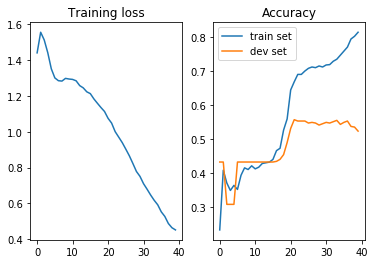

In [77]:
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.plot(loss_hist)
ax1.set_title('Training loss')
ax2.plot(acc_train_hist, label='train set')
ax2.plot(acc_dev_hist, label='dev set')
ax2.legend()
ax2.set_title('Accuracy')
plt.plot()

### Eval

In [78]:
model.eval()

MLP(
  (l1): Linear(in_features=3947, out_features=400, bias=True)
  (do1): Dropout(p=0.5, inplace=False)
  (l2): Linear(in_features=400, out_features=100, bias=True)
  (do2): Dropout(p=0.5, inplace=False)
  (l3): Linear(in_features=100, out_features=4, bias=True)
)

In [79]:
y_pred = model(X_dev)
y_pred = torch.argmax(y_pred, dim=1)
acc = (y_pred == y_dev).sum().item() / len(y_dev)
print(acc)

0.5237154150197628


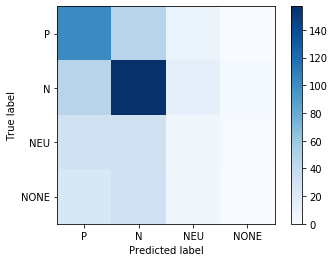

In [80]:
cm = confusion_matrix(y_dev, y_pred)
ax = plt.subplot(111)
im = ax.imshow(cm, cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=sentiment_classes,
       yticklabels=sentiment_classes,
       xlabel='Predicted label',
       ylabel='True label')
plt.show()

### Interpretation

In [81]:
sents = [
    "El día fue muy lindo",
    "El día fue muy feo",
    "Hoy me siento mal",
    "Ellos hacen compras",
    ""
]
sents = vectorizer.transform(sents).toarray()
sents = torch.tensor(sents).float().to(args.device)
pred = model(sents).argmax(dim=1)
y_num_to_text(pred)

['P', 'N', 'N', 'P', 'N']

In [82]:
def sort_by(word_probs, sentiment_index):
    # sentiment_index belongs to [0, 1, 2, 3]
    # which translates to ['P', 'N', 'NEU', 'NONE']

    sort_by = torch.argsort(-word_probs[:, sentiment_index])
    sorted_words = all_words[sort_by].long()
    sorted_words = vectorizer.inverse_transform(sorted_words)
    return [x[0] for x in sorted_words]

def print_best_and_worst_five(sorted_words, cl):
    print('Top 5 influencial words in class {}:'.format(cl))
    print('\t', sorted_words[:5])
    print('Worst 5 influencial words in class {}:'.format(cl))
    print('\t', sorted_words[-5:])
    print()


In [83]:
all_words = torch.eye(input_shape[1]).to(args.device)
word_probs = model(all_words)

sorted_words = sort_by(word_probs, 0)
print_best_and_worst_five(sorted_words, 'P')

sorted_words = sort_by(word_probs, 1)
print_best_and_worst_five(sorted_words, 'N')

sorted_words = sort_by(word_probs, 2)
print_best_and_worst_five(sorted_words, 'NEU')

sorted_words = sort_by(word_probs, 3)
print_best_and_worst_five(sorted_words, 'NONE')

Top 5 influencial words in class P:
	 ['guapa', 'buen', 'cierto', 'genial', 'ahí']
Worst 5 influencial words in class P:
	 ['joder', 'odio', 'feo', 'peor', 'triste']

Top 5 influencial words in class N:
	 ['triste', 'peor', 'feo', 'odio', 'joder']
Worst 5 influencial words in class N:
	 ['bonito', 'genial', 'cierto', 'buen', 'guapa']

Top 5 influencial words in class NEU:
	 ['sentimiento', 'quiera', 'sobrevives', 'compras', 'resultad']
Worst 5 influencial words in class NEU:
	 ['joder', 'odio', 'feo', 'peor', 'triste']

Top 5 influencial words in class NONE:
	 ['fecha', 'semana', 'zona', 'tuit', 'quedo']
Worst 5 influencial words in class NONE:
	 ['joder', 'odio', 'feo', 'peor', 'triste']

